##### Numerical Computation: HW12

##### Andrew Pickner

I worked alone on this assignment.

---

In [1]:
import numpy as np
import pandas as pd

import scipy.integrate

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def forwardEuler(f, U_0, h, T):
    n_iters = int(round(float(T)/h))
    u = np.zeros((n_iters+1, len(U_0)))
    t = np.linspace(0, n_iters*h, len(u))
    u[0] = U_0
    for n in range(n_iters):
        u[n+1] = u[n] + h*f(t[n], u[n])
    return u, t

In [3]:
def rungeKutta2(f, U_0, h, T):  
    n_iters = int(round(float(T)/h)) 
    u = np.zeros((n_iters+1, len(U_0)))
    t = np.linspace(0, n_iters*h, len(u))
    u[0] = U_0
      
    for n in range(n_iters):
        Y_star = u[n] + (h/2)*f(t[n], u[n])
        u[n+1] = u[n] + h*f((t[n] + (h/2)), Y_star)
    return u, t

In [4]:
# https://en.wikipedia.org/wiki/Runge–Kutta_methods
def rungeKutta4(f, U_0, h, T):  
    n_iters = int(round(float(T)/h)) 
    u = np.zeros((n_iters+1, len(U_0)))
    t = np.linspace(0, n_iters*h, len(u))
    u[0] = U_0
      
    for n in range(n_iters):
        k1 = f(t[n], u[n])
        k2 = f(t[n] + (h/2), u[n] + (h * (k1/2)))
        k3 = f(t[n] + (h/2), u[n] + (h * (k2/2)))
        k4 = f(t[n] + h, u[n] + (h * k3))
        u[n+1] = u[n] + (h/6)*(k1 + (2*k2) + (2*k3) + k4)
    return u, t

In [5]:
def SIR_Demo(h, method, num_days=140, b=1/2, k=1/3, v=0):
    # If we guess that each infected would make a possibly infecting contact every two days, then  b =  1/2. 
    # This is simply a guess.
    b = b
    # We have already estimated the average period of infectiousness at three days, so that would suggest k = 1/3
    # This is simply a guess.
    k = k
    """Test case using a SIR model."""
    def f(t, u):
        S, I, R = u
        # ds/dt = -b * s(t) * i(t)
        # di/dt = b * s(t) * i(t) - k * i(t)
        # dr/dt = k * i(t)
        return np.array([-b*S*I + v*R, b*S*I - k*I, k*I - v*R])
    
    # time delta: change in time
    dt = h            
    
    # time: total time in days
    T = num_days
    
    # S = S(t): is the number of susceptible individuals,
    S_0 = 7.9e6
    # I = I(t): is the number of infected individuals,
    I_0 = 10
    # R = R(t): is the number of recovered individuals,
    R_0 = 0

    # i(t) = I(t)/N : the infected fraction of the population,
    i_0 = 1.27e-6
    # s(t) = S(t)/N : the susceptible fraction of the population,
    s_0 = 1-i_0
    # r(t) = R(t)/N : the recovered fraction of the population,
    r_0 = 0
    
    # initial condition vector
    U_0 = [s_0, i_0, r_0]

    # solving the system of ODEs using euler's method 
    u, t = method(f, U_0, dt, T)
        
    S = u[:,0]
    I = u[:,1]
    R = u[:,2]
    fig = plt.figure()
    s1, i1, r1 = plt.plot(t, S, t, I, t, R)
    fig.legend((s1, i1, r1), ('S', 'I', 'R'))
    plt.xlabel('days')
    plt.show()

    # Consistency check:
    N = S[0] + I[0] + R[0]
    eps = 1E-12  # Tolerance for comparing real numbers
    for n in range(len(S)):
        SIR_sum = S[n] + I[n] + R[n]
        if abs(SIR_sum - N) > eps:
            print('*** consistency check failed: S+I+R={} != {}'.format(SIR_sum, N))

---

### SELECTING H:

[Euler's Method: SIR](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-eulers-method-for-systems) Also where the infamous graph is referenced (I mention it a million times below).

[ODE Model: SIR](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model)

[Background: SIR](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-background-hong-kong-flu)

**Other resources:**

[Super dope write-up:](http://hplgit.github.io/Programming-for-Computations/pub/p4c/._p4c-bootstrap-Python021.html) Kinda involving a lot of the computational and numerical theory, as well as explaining some of the constants and other disease-related aspects as well.

So, forward Euler is first order and it's error is bound by $\mathcal{O}(h)$. Runge-Kutta 2 is second order (thus the 2), and it's global error is bound by $\mathcal{O}(h^2)$ so it should do a little better than Euler's method (so long as $h$ is small). Further, looking ahead towards RK4, following from the logic of RK2, this is obviously fourth order and I also assume its error is bound by $\mathcal{O}(h^4)$ so it should perform the best (again, assuming $h$ is small). However, what I've gleaned is that we can theoretically make $h$ as small as we want, but the computational cost grows as we do this. Thus, we need to find an $h$ that is *sufficiently* small given what we are computing. Here, we are building a tool that can model a disease within a population and I believe we are "calibrating" our tool by choosing this $h$ so that it matches the graph on the website. Although I could let my code run for a long time with an incredibly small $h$, I'd rather not.

- Initially, I just wanted to get up and running with my code so I loop through 1-10 for testing purposes, but I figured this test *might* tell me something (once code was all debugged). Also, these $h$'s are relatively plausible.
    - When $h=1$, we see a *relatively* similar graph to the one on the website (Euler's method).
    - As $h$ grows, we see the graph become more jagged, and we see the infection curve shift to the right (unlike the graph on the website
        - Also interesting to note, although the graph does look a little jagged and it doesn't match the website at all, RK2 at $h=10$ is far better than Euler's method. Important for future studies: when $h=1$, RK2 also outperforms Euler's method, and looks really close to the graph we're trying to reproduce.
        - In fact, RK2 holds on until around $h\approx 3$ and still very closely resembles the graph from the website.
        - Finally, I skipped this study for RK4 because I had a few other ideas in mind.
- Then, because I knew it would be far better to have $h<1$, I gave this a try similar to my last little experiment. I started at $0.1$ and incremented by $0.1$ until we hit $1$. Of course rounding errors mess with this a little, it was still a helpful experiment for Euler's method.
    - Right off the bat, it was clear our initial $h$ value: $0.1$ is the closest to the graph from the website we've seen yet.
    - For $h\leq0.5$, we see incredibly similar graphs to that on the website. 
    - As we see: $0.6\leq h \leq 1$, the graph *looks* similar but the infected curve is slightly shifted to the right. (this analysis is all for Euler's method...)
        - Finally, as Euler's method degrades as $h$ approaches $1$, we simply don't see this same behavior for RK2. The difference in the RK2 graphs is extremely unnoticeable, and they look incredibly similar to the graph depicted on the website.
- Although not necessarily relevant to me finding my value for $h$, I thought of several *interesting* values for $h$ I wanted to try.
    - 140, so we'd have one *bin* or iteration.
    - 70, same reason as above but we'd have 2.
    - 35, same reason as above but we'd have 4.
    - 17.5, same reason as above but we'd have 8.
    - 8.75, same reason as above but we'd have 16.
    - 4.375, same reason as above but we'd have 32.
    - 1, this is equivalent to 1 day, seemed like a good baseline test.
    - 10, also seemed like a good baseline test.
    - (1/24) = 0.04167, this is effectively equivalent to 1 hour. **This is what I began to lean towards relatively early on (more will be explained later)**
- Finally, I make $h$ smaller exponentially to see if I could see anything interesting in the graphs. Unfortunately, nothing came to me as all of the graphs pretty much looked the same for each of the respective methods I ran this study on.
    - This is where I became pretty sure I would make $\boxed{h=\frac{1}{24}}$ for all the methods because it also works for each of them incredibly well.
        - Although, I finally realized after restarting the kernel and running all several times that small $h$'s would make RK2 and RK4 run longer...
    
The reason I like this decision is because 1 hour seems like a pretty reasonable time step and it **is** relatively small. Besides, $h=0.5$ or simply 12 hours, seems like it just about begins to shift Euler's infection curve. However, I realized after I wrote this ginormous block of text that this isn't *really* what the question is asking... I *feel* like you're asking what the largest possible $h$ is that it still matches the graph from the website.

- **Euler's method:** $h\leq 0.5$, so $h$ can be as large as $0.5$ and still match the graph on the website.
- **RK2:** $h\leq 3$, so $h$ can be as large as $3$ and still match the graph on the website.
- **RK4:** $h\leq 6$, so $h$ can be *almost* as large as $6$ and still match the graph on the website.
  
---

1


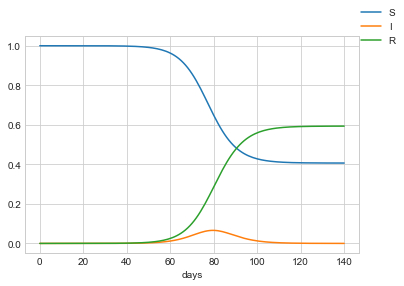

2


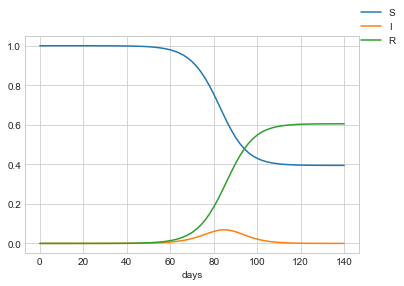

3


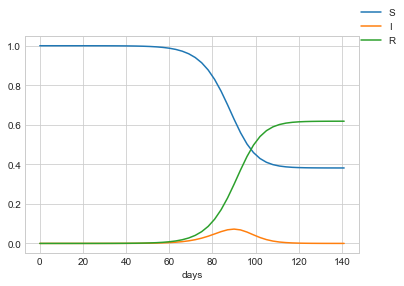

4


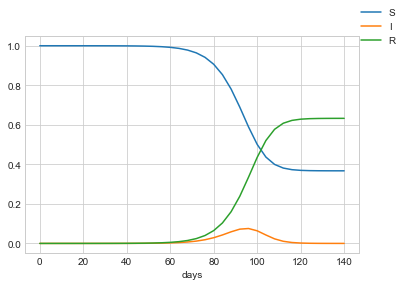

5


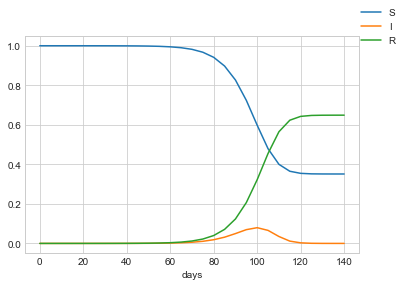

6


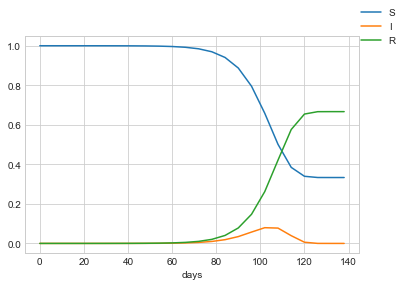

7


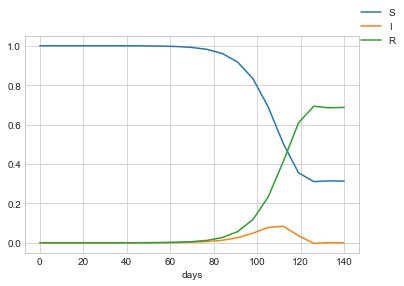

8


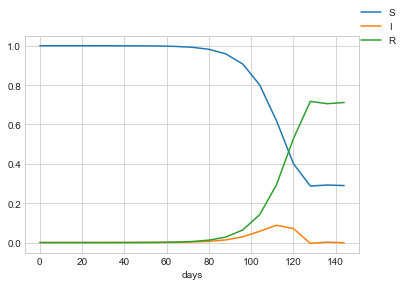

9


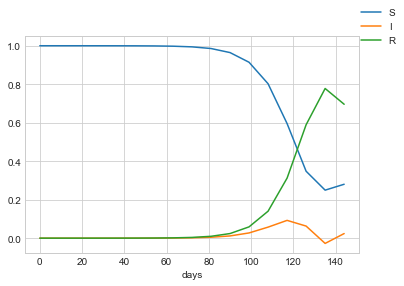

10


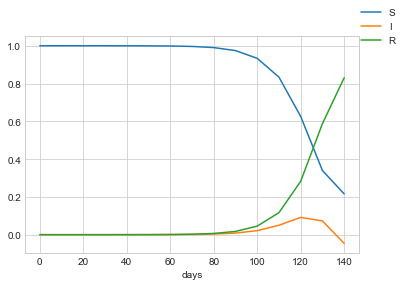

In [6]:
for i in range(1, 11):
    print(i)
    SIR_Demo(i, forwardEuler)

0.1


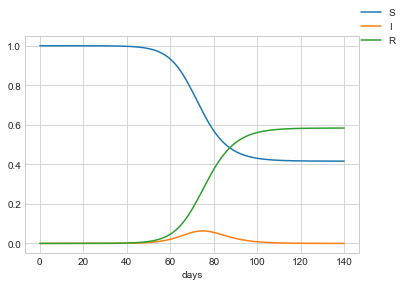

0.2


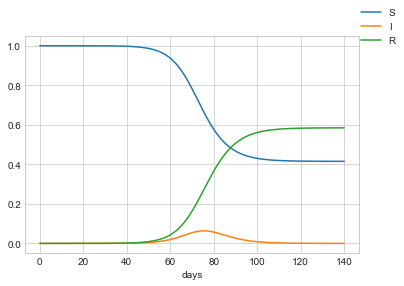

0.30000000000000004


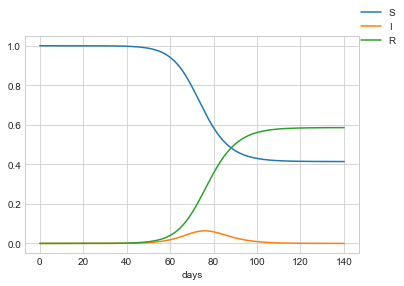

0.4


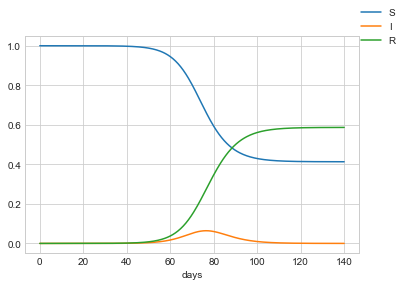

0.5


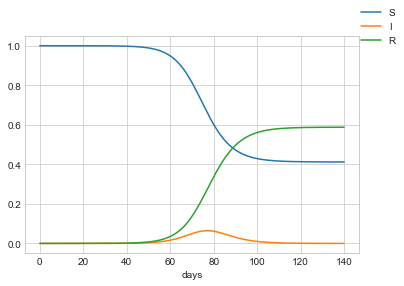

0.6


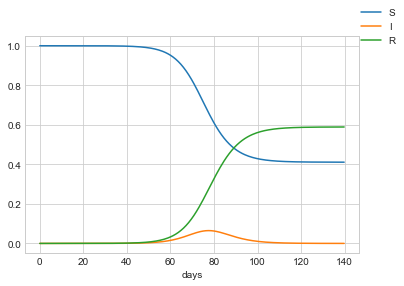

0.7


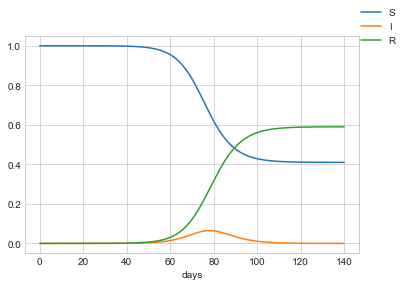

0.7999999999999999


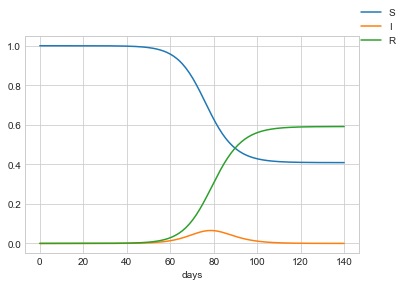

0.8999999999999999


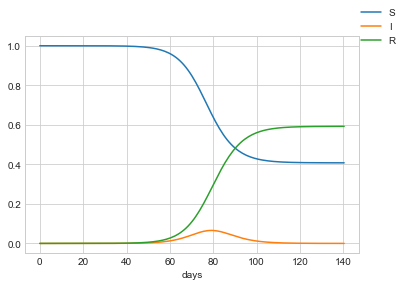

0.9999999999999999


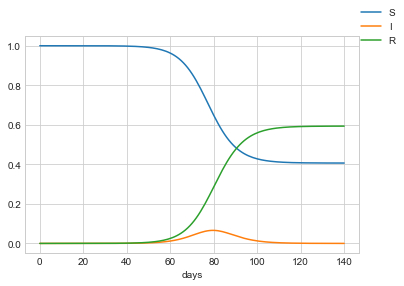

In [7]:
x = 0.1
for i in range(0, 10):
    print(x)
    SIR_Demo(x, forwardEuler)
    x+=0.1

0.041666666666666664


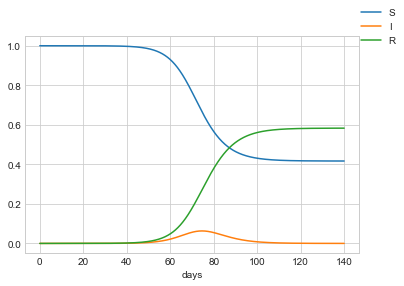

1


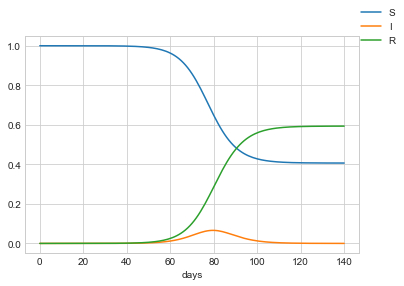

4.375


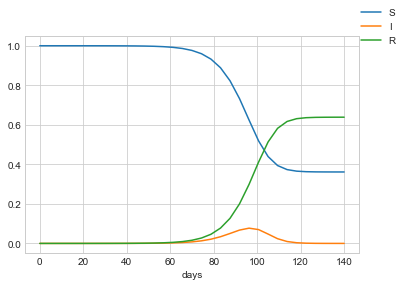

8.75


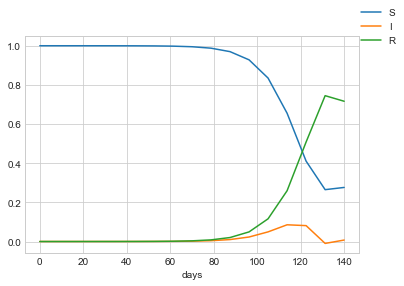

10


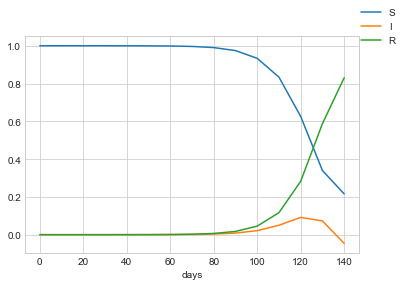

17.5


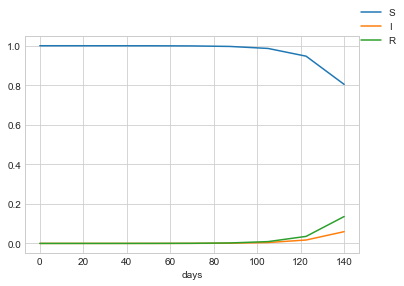

35


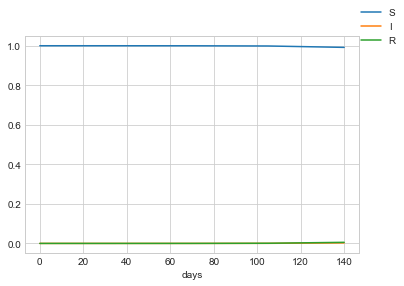

70


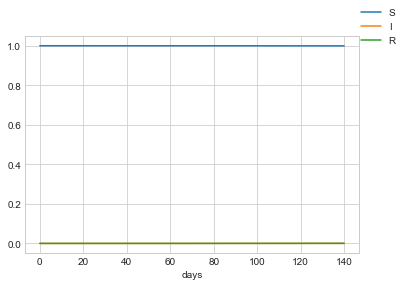

140


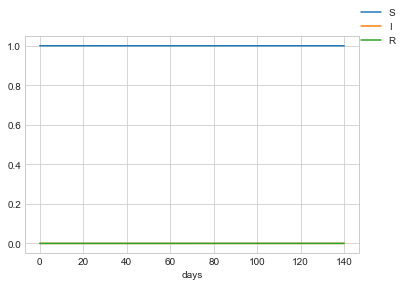

In [8]:
interesting_list = [(1/24), 1, 4.375, 8.75, 10, 17.5, 35, 70, 140]
for item in interesting_list:
    print(item)
    SIR_Demo(item, forwardEuler)

1


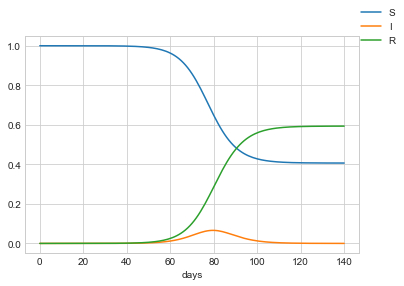

0.5


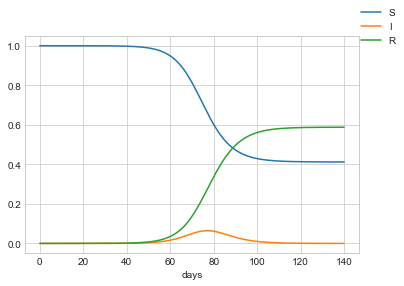

0.25


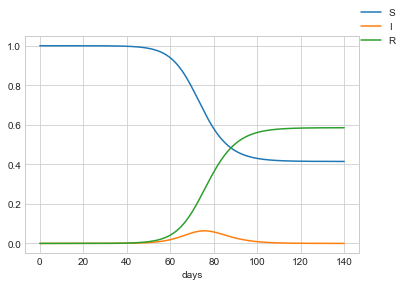

0.125


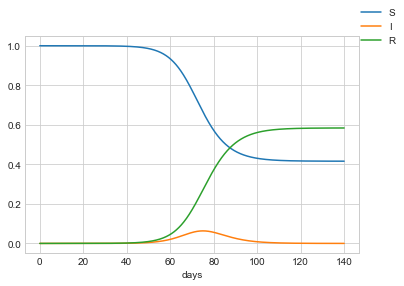

0.0625


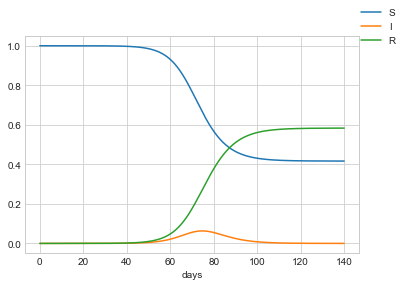

0.03125


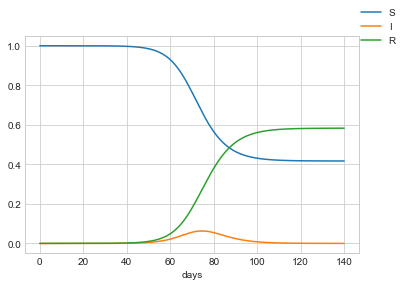

0.015625


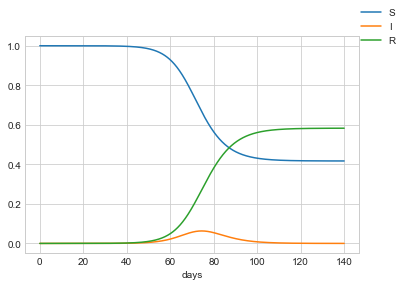

0.0078125


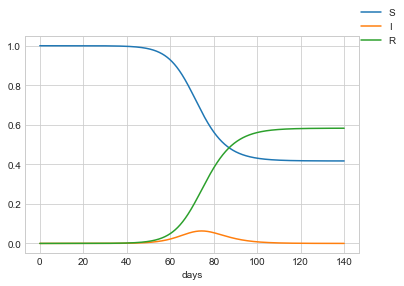

0.00390625


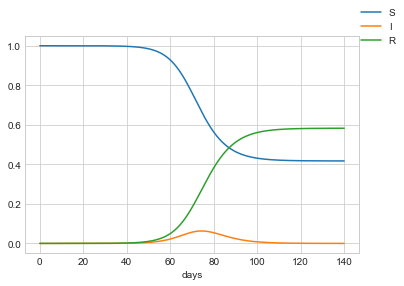

0.001953125


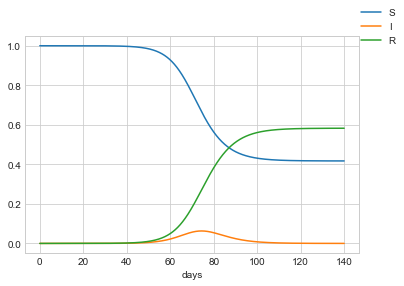

0.0009765625


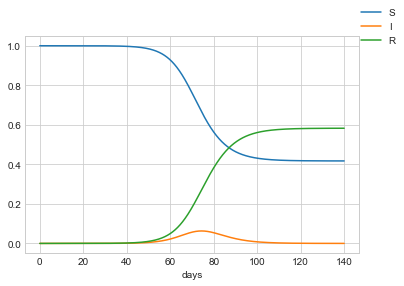

0.00048828125


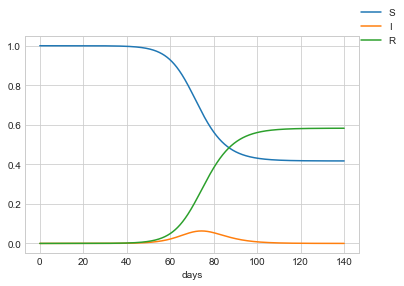

0.000244140625


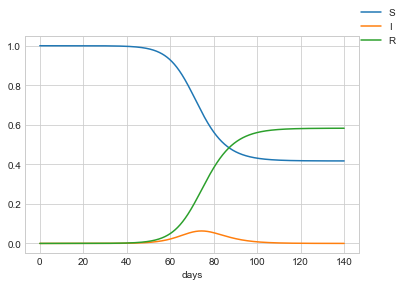

0.0001220703125


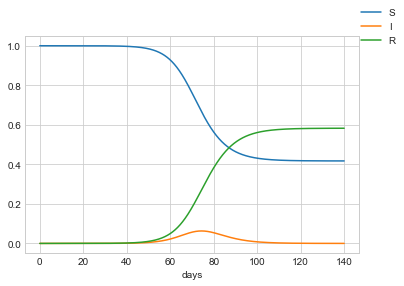

6.103515625e-05


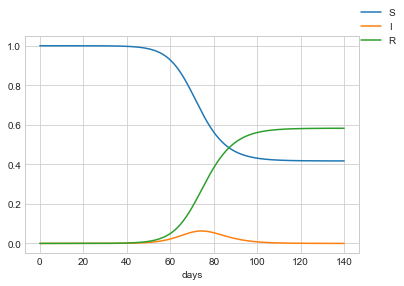

In [9]:
x = 1
for i in range(15):
    x = (2**(-i))
    print(x)
    SIR_Demo(x, forwardEuler)

1


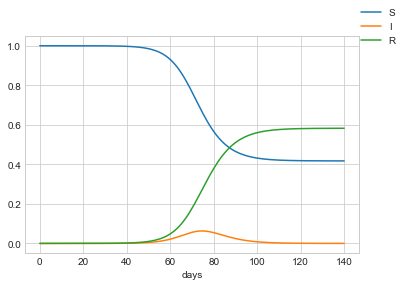

2


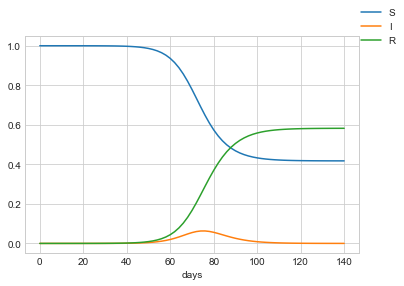

3


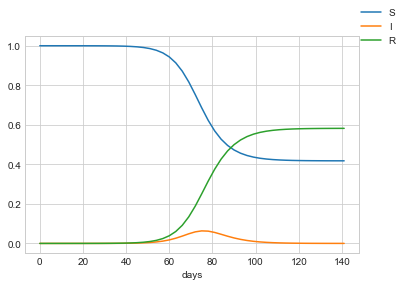

4


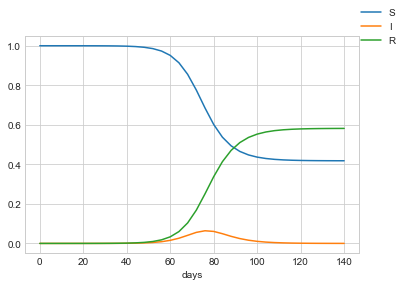

5


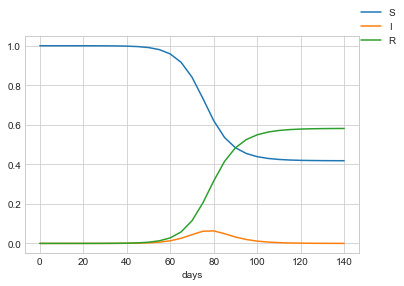

6


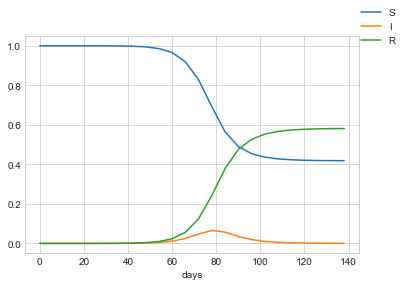

7


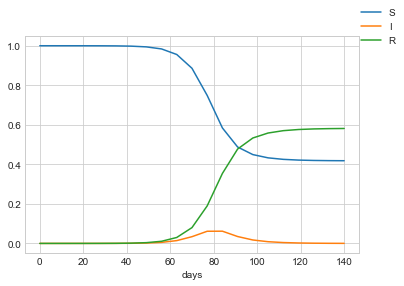

8


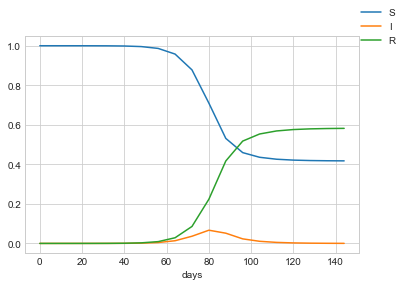

9


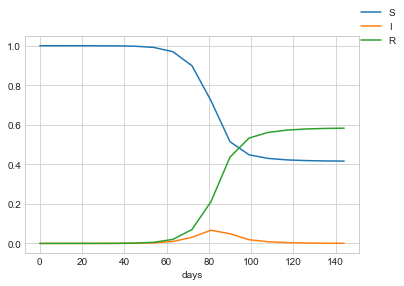

10


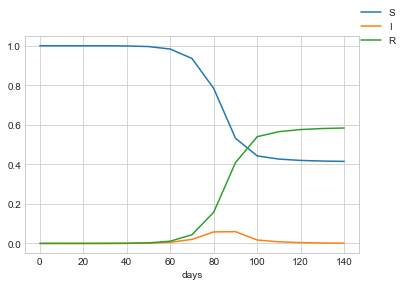

In [10]:
for i in range(1, 11):
    print(i)
    SIR_Demo(i, rungeKutta2)

0.1


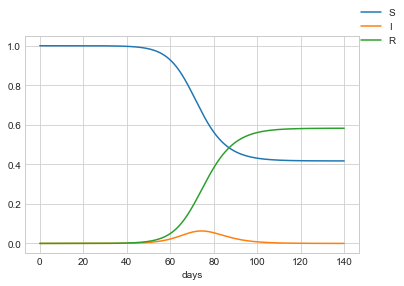

0.2


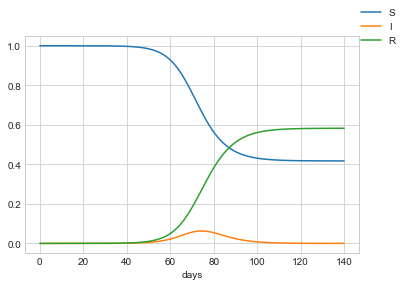

0.30000000000000004


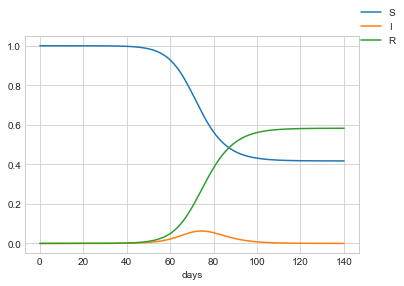

0.4


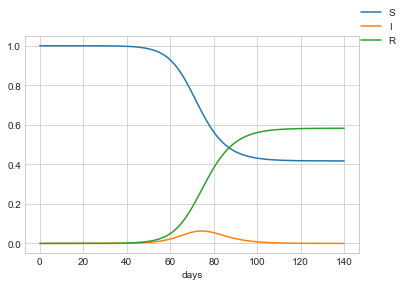

0.5


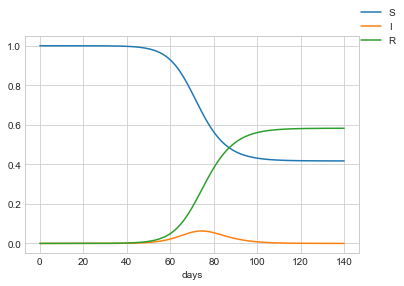

0.6


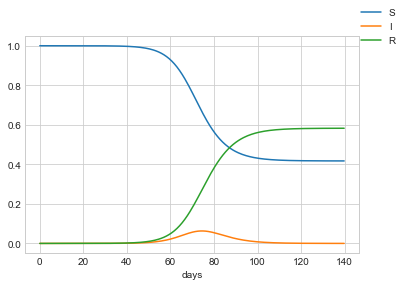

0.7


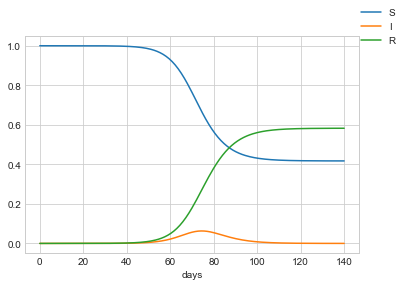

0.7999999999999999


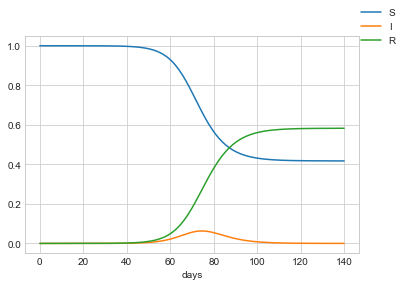

0.8999999999999999


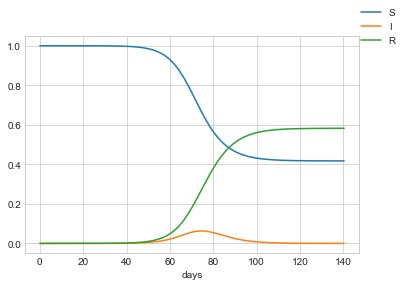

0.9999999999999999


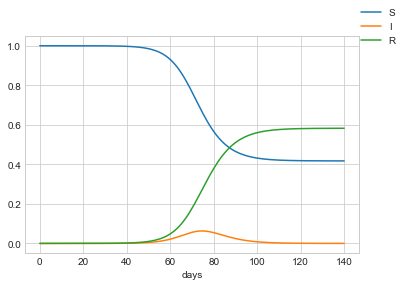

In [11]:
x = 0.1
for i in range(0, 10):
    print(x)
    SIR_Demo(x, rungeKutta2)
    x+=0.1

0.041666666666666664


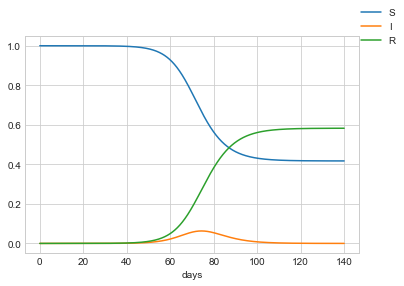

1


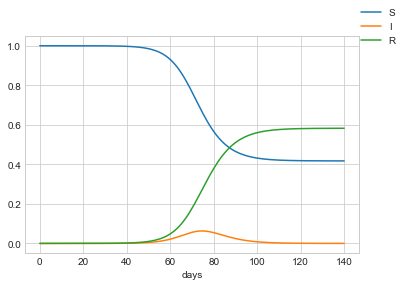

4.375


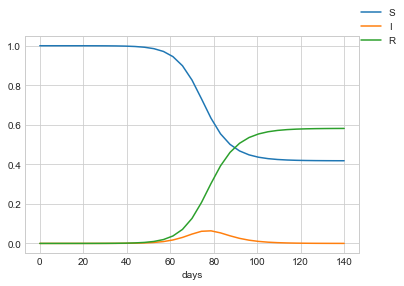

8.75


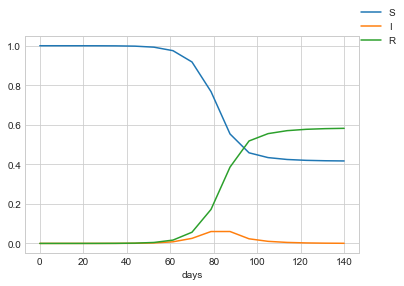

10


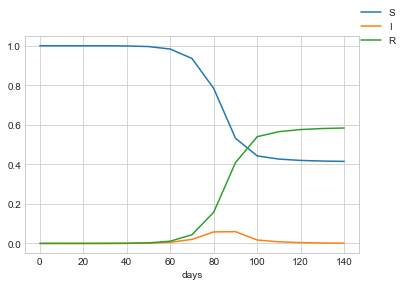

17.5


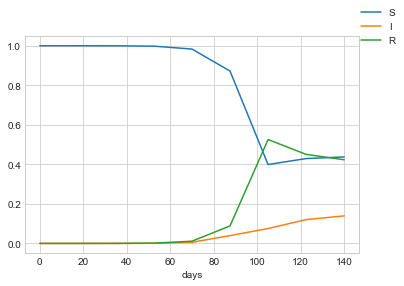

35


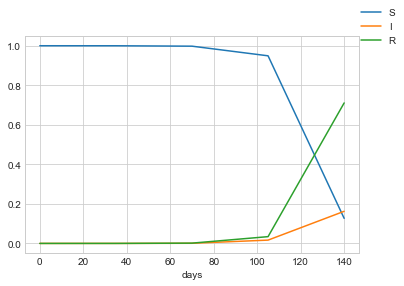

70


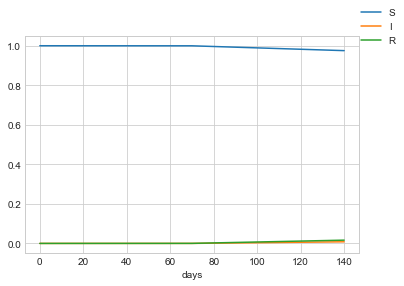

140


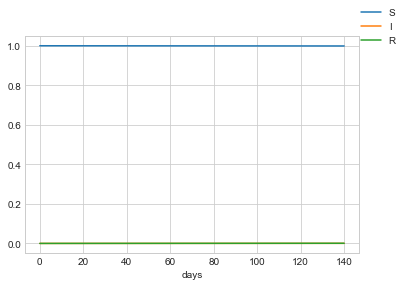

In [12]:
for item in interesting_list:
    print(item)
    SIR_Demo(item, rungeKutta2)

1


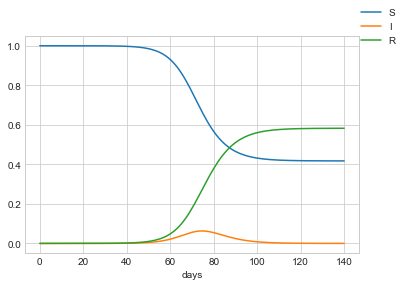

0.5


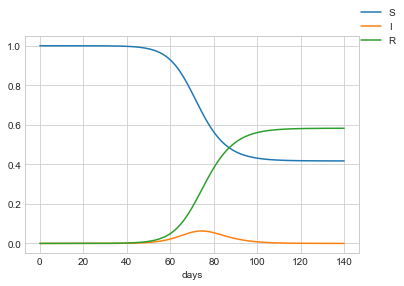

0.25


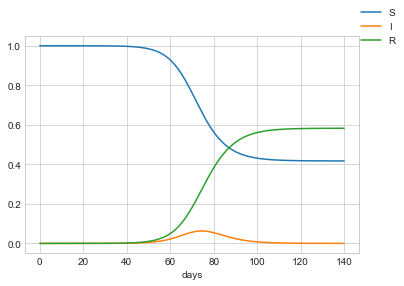

0.125


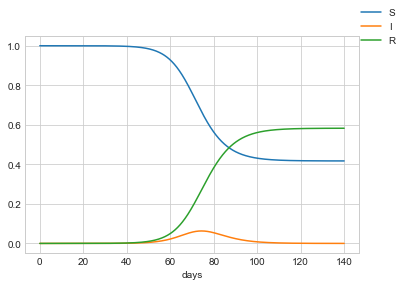

0.0625


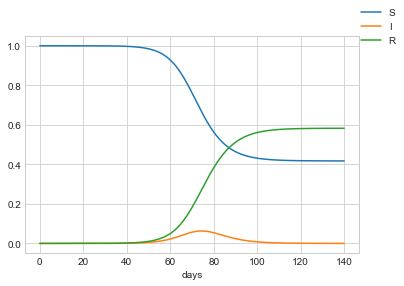

0.03125


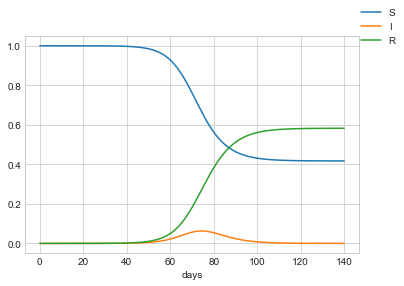

0.015625


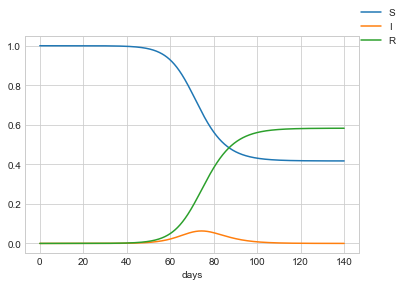

0.0078125


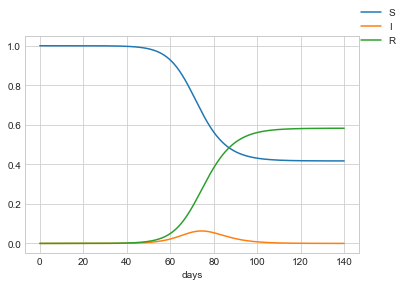

0.00390625


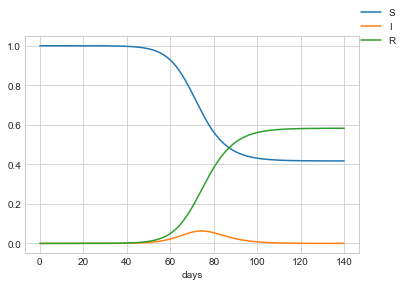

0.001953125


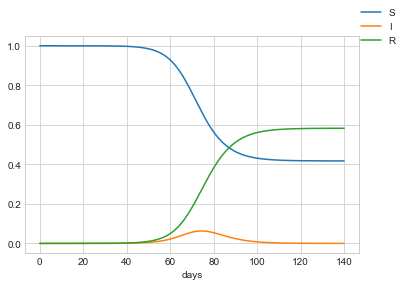

0.0009765625


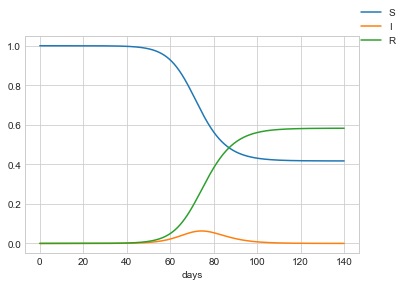

0.00048828125


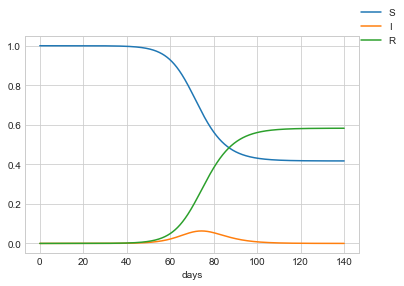

0.000244140625


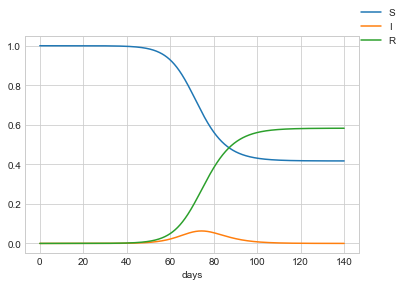

0.0001220703125


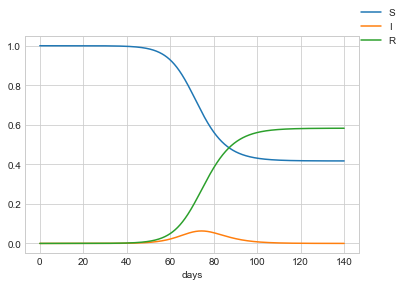

6.103515625e-05


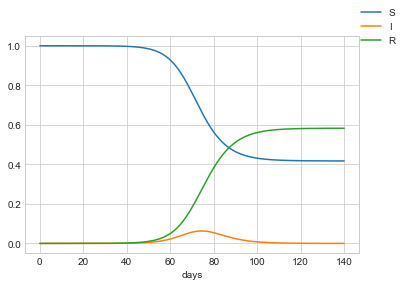

In [13]:
x = 1
for i in range(15):
    x = (2**(-i))
    print(x)
    SIR_Demo(x, rungeKutta2)

1


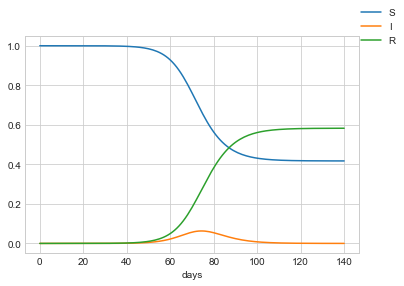

0.5


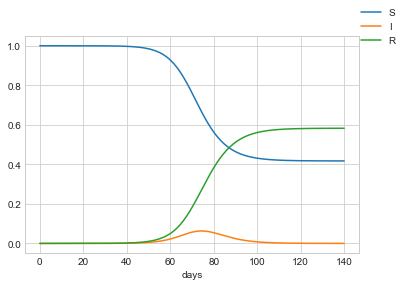

0.25


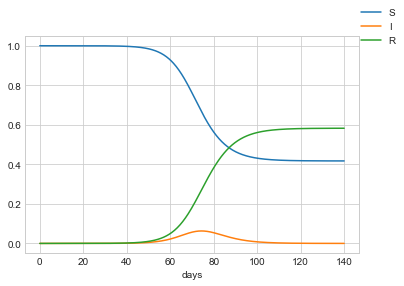

0.125


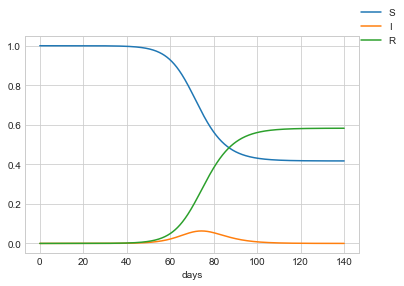

0.0625


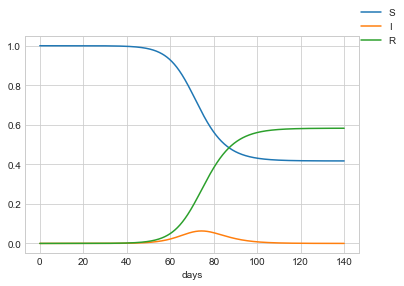

0.03125


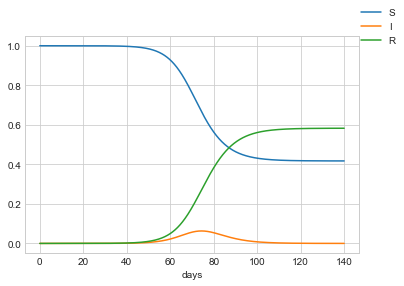

0.015625


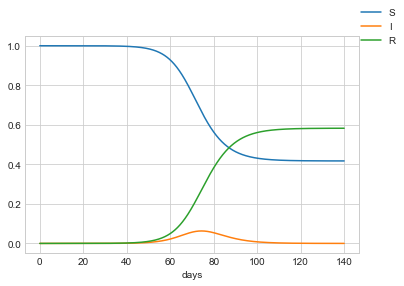

0.0078125


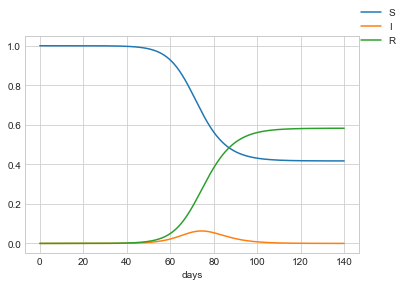

0.00390625


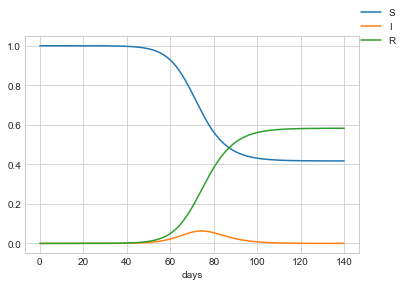

0.001953125


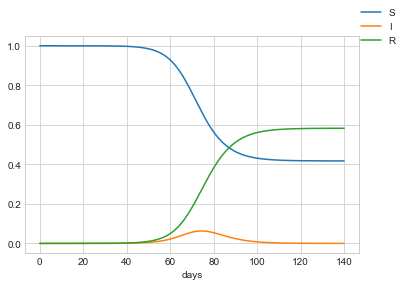

0.0009765625


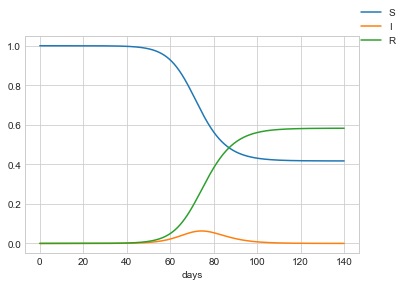

0.00048828125


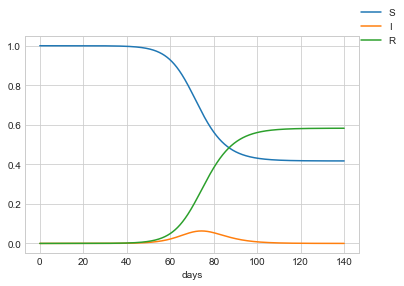

0.000244140625


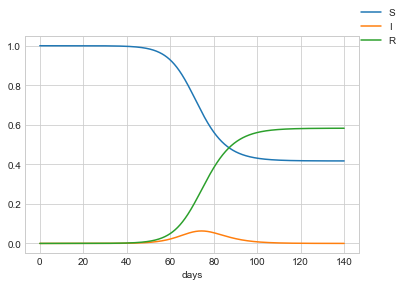

0.0001220703125


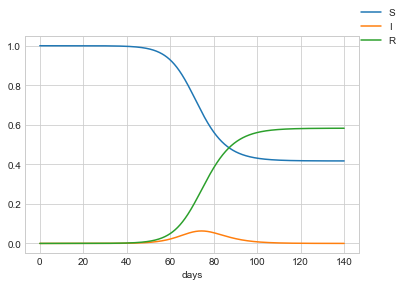

6.103515625e-05


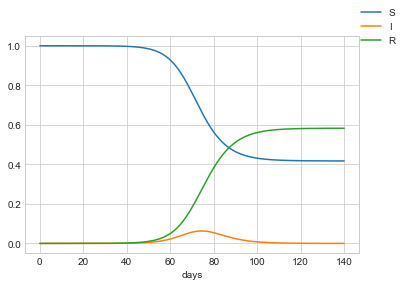

In [14]:
x = 1
for i in range(15):
    x = (2**(-i))
    print(x)
    SIR_Demo(x, rungeKutta4)

0.041666666666666664


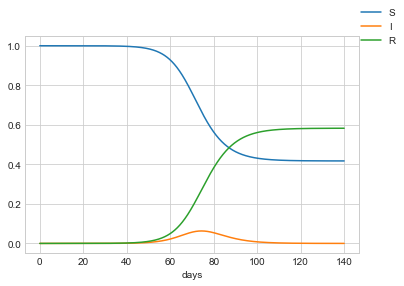

1


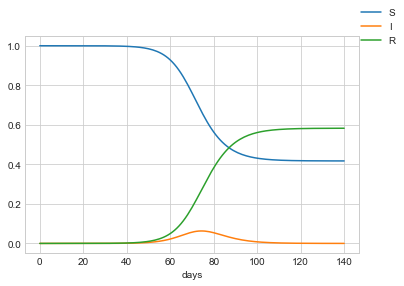

4.375


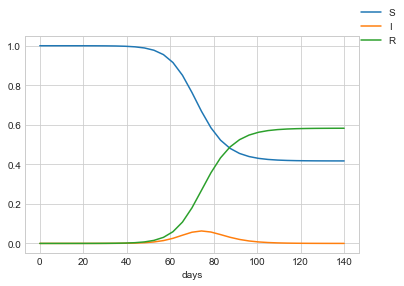

8.75


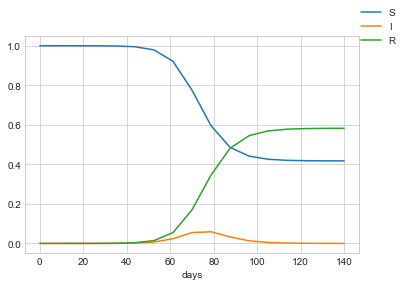

10


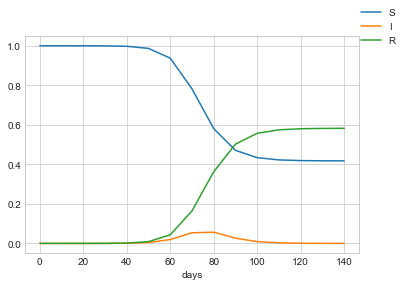

17.5


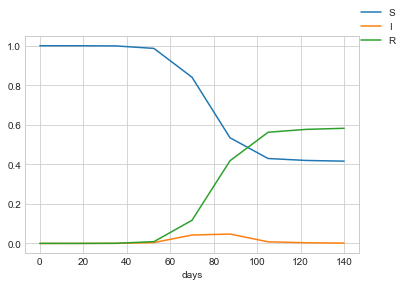

35


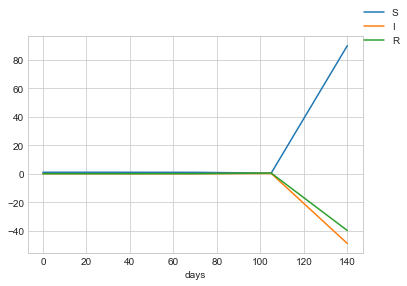

70


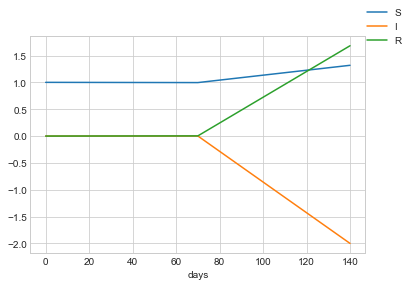

140


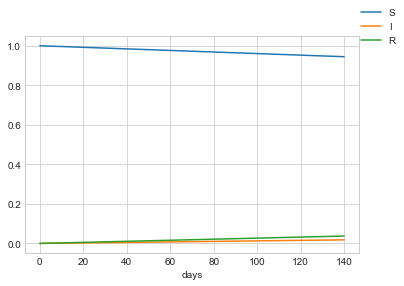

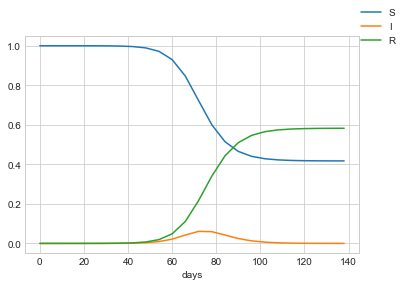

In [15]:
for item in interesting_list:
    print(item)
    SIR_Demo(item, rungeKutta4)
SIR_Demo(6, rungeKutta4)    

In [16]:
def f(t, u):
    # If we guess that each infected would make a possibly infecting contact every two days, then  b =  1/2. 
    # This is simply a guess.
    b = 1/2
    # We have already estimated the average period of infectiousness at three days, so that would suggest k = 1/3
    # This is simply a guess.
    k = 1/3
    S, I, R = u
    # ds/dt = -b * s(t) * i(t)
    # di/dt = b * s(t) * i(t) - k * i(t)
    # dr/dt = k * i(t)
    return np.array([-b*S*I, b*S*I - k*I, k*I])
    
# num days
T = 140
# s(t) = S(t)/N : the susceptible fraction of the population,
s_0 = 1
# i(t) = I(t)/N : the infected fraction of the population,
i_0 = 1.27e-6
# r(t) = R(t)/N : the recovered fraction of the population,
r_0 = 0

# initial condition vector
U_0 = [s_0, i_0, r_0]    

In [17]:
n = 5

hs = [(2**-i) for i in range(n)]
truth = [scipy.integrate.solve_ivp(f, (0.0, T), U_0, max_step=h).y for h in hs]
RK2 = [rungeKutta2(f, U_0, h, T) for h in hs]
RK4 = [rungeKutta4(f, U_0, h, T) for h in hs]

print(hs)
print("truth: ", len(truth))
print("RK2: ", len(RK2))
print("RK4: ", len(RK4))

# print("shape truth: ", np.array(truth).shape)
print("shape RK2: ", np.array(RK2).shape)
print("shape RK4: ", np.array(RK4).shape)

[1, 0.5, 0.25, 0.125, 0.0625]
truth:  5
RK2:  5
RK4:  5
shape RK2:  (5, 2)
shape RK4:  (5, 2)


---

I really struggled at getting the scipy method to give me output that I knew how to work with. I would have used that as my truth and found the error that way. Unfortunately, I couldn't do this.

---

### COVID BONUS?

I thought I'd fool around and see how this looked with some COVID numbers!

I was going to plot actual data to

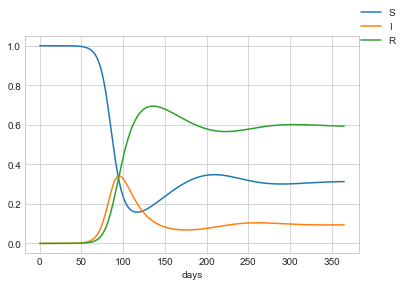

In [18]:
# takes the avg. person 4-5 days to start showing symptoms
# infectiousness goes away 10 days after symptoms show up
# k = 1 / 14.5
k=1/14.5

# maybe because people dont develop symptoms for 4.5 days so they can transmit the disease then?
# b = 1/5
b=1/4.5

# i couldn't find conclusive data on immunity...
# moderna says their vaccine will provide 3 months,
# i saw various studies that say natural immunity is in the 3-12 month range.
# who knows... 
v=1/90

SIR_Demo((1/24), rungeKutta4, num_days=365, b=b, k=k, v=v)

In [19]:
df = pd.read_csv('/Users/AndrewMacbook/Downloads/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,01/22/2020,CO,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
1,01/23/2020,CO,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
2,01/24/2020,CO,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
3,01/25/2020,CO,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
4,01/26/2020,CO,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
